<a href="https://colab.research.google.com/github/AnovaYoung/LSTM_GAP/blob/main/LSTM_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here

df = pd.read_csv("GAP_Cleaned.csv")

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date,Time
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16,17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16,17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16,17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16,17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16,17:28:00


In [ ]:
df['DateTime'] = df['Date'] + ' ' + df['Time']

df['DateTime'] = pd.to_datetime(df['DateTime'])

df.drop(['Date', 'Time'], axis=1, inplace=True)

print(df.head())

   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            DateTime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  


In [ ]:
df.sort_values(by='DateTime', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   DateTime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 142.5 MB


In [ ]:
#assign size for data subset
#take random data subset
subset_size = int(len(df) * 0.01)
data_subset = df.iloc[:subset_size]

In [ ]:
#split data subset 80/20 for train/validation
train_size = int(len(data_subset) * 0.8)

train_df = data_subset.iloc[:train_size]
val_df = data_subset.iloc[train_size:]

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
seq_arrays = []
seq_labs = []

In [ ]:
# Define the sequence length and predictive horizon
seq_length = 30
ph = 5

# We're only interested in the 'Global_active_power' column for this task
feat_cols = ['Global_active_power']

# Iterate through the DataFrame to create input/output sequences
for i in range(len(train_df) - seq_length - ph + 1):
    # Extract the GAP measurements as input
    seq = train_df[feat_cols][i:i+seq_length].values
    # Extract the GAP measurement at the predictive horizon as the output
    label = train_df[feat_cols][i+seq_length+ph-1:i+seq_length+ph].values
    # Append to our lists
    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert lists to numpy arrays and ensure the data type is float32
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).squeeze().astype(np.float32)


In [ ]:
# Correcting the assertions
assert(seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, 1)), f"Expected shape: {(len(train_df) - seq_length - ph + 1, seq_length, 1)}, but got {seq_arrays.shape}"
assert(seq_labs.shape == (len(train_df) - seq_length - ph + 1,)), f"Expected shape: {(len(train_df) - seq_length - ph + 1,)}, but got {seq_labs.shape}"

In [ ]:
seq_arrays.shape

(16567, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the above code are used to verify that the data arrays seq_arrays and seq_labs conform to the expected dimensions after preprocessing acting as a form of runtime error checking. By ensuring that the shapes of these arrays match the anticipated structure required for LSTM model training early error detection is made easier and debugging more straightforward.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [ ]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
        input_shape=(30,nb_features),
        units=1,
        return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
        units=3,
        return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
        )

print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 1)             12        
                                                                 
 dropout (Dropout)           (None, 30, 1)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 60        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 76 (304.00 Byte)
Trainable params: 76 (304

/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 - 0s - loss: 2.1601 - mse: 2.1601 - val_loss: 1.0934 - val_mse: 1.0934 - 353ms/epoch - 11ms/step
Epoch 3/100
32/32 - 0s - loss: 1.4220 - mse: 1.4220 - val_loss: 0.1725 - val_mse: 0.1725 - 353ms/epoch - 11ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9648 - mse: 0.9648 - val_loss: 0.1184 - val_mse: 0.1184 - 321ms/epoch - 10ms/step
Epoch 5/100
32/32 - 0s - loss: 0.8360 - mse: 0.8360 - val_loss: 0.1086 - val_mse: 0.1086 - 316ms/epoch - 10ms/step
Epoch 6/100
32/32 - 0s - loss: 0.8141 - mse: 0.8141 - val_loss: 0.1020 - val_mse: 0.1020 - 325ms/epoch - 10ms/step
Epoch 7/100
32/32 - 0s - loss: 0.7815 - mse: 0.7815 - val_loss: 0.1063 - val_mse: 0.1063 - 319ms/epoch - 10ms/step
Epoch 8/100
32/32 - 0s - loss: 0.7686 - mse: 0.7686 - val_loss: 0.1007 - val_mse: 0.1007 - 349ms/epoch - 11ms/step
Epoch 9/100
32/32 - 0s - loss: 0.7479 - mse: 0.7479 - val_loss: 0.1054 - val_mse: 0.1054 - 315ms/epoch - 10ms/step
Epoch 10/100
32/32 - 0s - loss: 0.7361 - mse: 0.7361 - val_loss: 0.1004 - val_mse: 0.1004 - 

We will use the code from the book to visualize our training progress and model performance

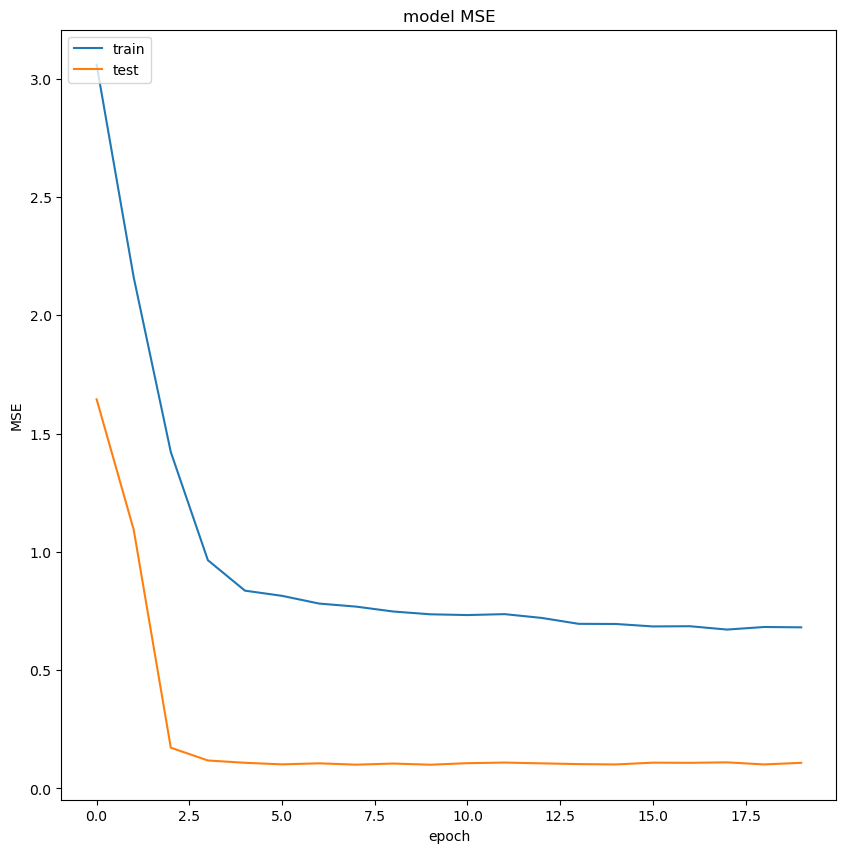

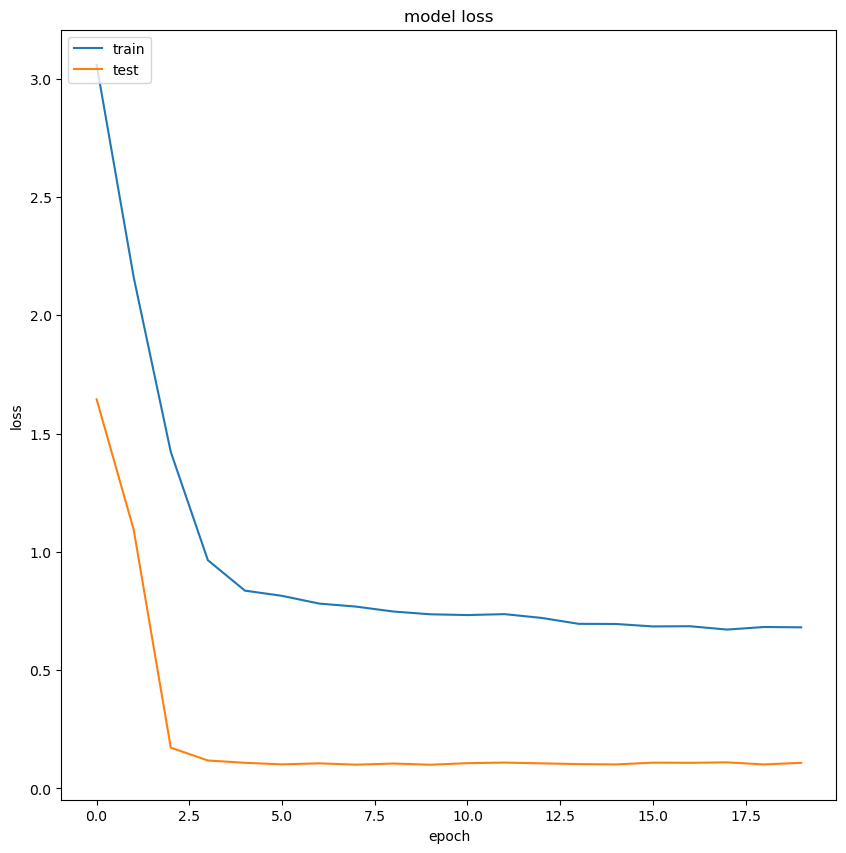

In [ ]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function in Keras is designed to standardize the lengths of sequences in a dataset by either truncating them or padding them with a specified value, typically zero, so that all sequences in the dataset have the same length. Its particularly useful for preparing sequences of different lengths for input into neural networks, such as LSTMs, that require input data to be of a uniform size

In [ ]:
val_arrays = []
val_labs = []

# Iterate through val_df to create sequences starting with a minimum of two readings
for i in range(2, len(val_df) - ph + 1):
    seq = val_df['Global_active_power'][:i].tolist()
    label = val_df['Global_active_power'][i + ph - 1] # The label is the GAP measurement at the predictive horizon
    val_arrays.append(seq)
    val_labs.append(label)

# pad the sequences and convert to numpy arrays
val_arrays_padded = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

val_labs = np.array(val_labs, dtype=np.float32)

# Ensure the padded sequences are in the correct format (float32)
val_arrays = np.array(val_arrays_padded, dtype=np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [ ]:
# Predict on the validation set
y_pred = model.predict(val_arrays)
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
# Calculate MSE manually
mse = np.mean(np.square(y_true_test - y_pred))
print('\nManually calculated MSE: {}'.format(mse))


130/130 [==============================] - 0s 1ms/step

Manually calculated MSE: 3.700521469116211


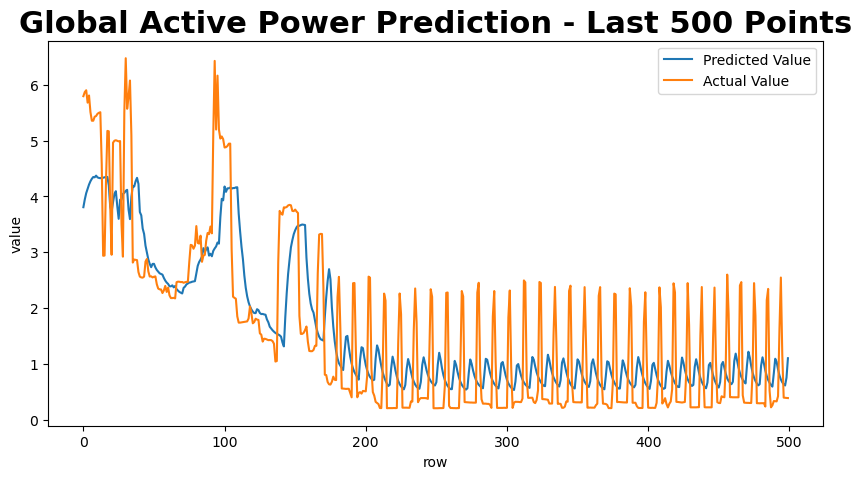

In [ ]:

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model's performance, as indicated by the loss curve demonstrates effective learning with a significant reduction in loss for both the training and validation datasets, suggesting it has captured underlying patterns in the data. The convergence of training and validation loss, with the validation loss being lower and not showing signs of increase, indicates good generalization without overfitting. To further improve the model I could explore adding more epochs of training until the loss fully plateaus, adjust hyperparameters such as batch size, or modify the model architecture with more units or layers to better capture complexities in the dataset.

## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: A different learning rate can help the model converge more effectively during training by controlling the step size. Altering the shape can provide the model with a different temporal context, which could be more helpful in capturing the relevant patterns in the data for predictions. Finally, changing the number of hidden layers and units within those layers can adjust the model's capacity, enabling it to model more complex relationships in the data or prevent overfitting.


In [ ]:
# play with your ideas for optimization here

learning_rate = 0.001
seq_length = 30
units_first_layer = 50
units_second_layer = 20

model_path = 'LSTM_model_optimized.h5'

model = Sequential()

# Add first LSTM layer
model.add(LSTM(
        input_shape=(seq_length, nb_features),
        units=units_first_layer,
        return_sequences=True))
model.add(Dropout(0.2))

# Add second LSTM layer with more units
model.add(LSTM(
        units=units_second_layer,
        return_sequences=False))
model.add(Dropout(0.2))

# Final dense layer
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

# Compile the model with a lower learning rate Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
        )

print(history.history.keys())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                5680      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 16101 (62.89 KB)
Trainable params: 16101

In [ ]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
val_arrays = []
val_labs = []

for i in range(2, len(val_df) - ph + 1):
    seq = val_df['Global_active_power'][:i].tolist()
    label = val_df['Global_active_power'][i + ph - 1]
    val_arrays.append(seq)
    val_labs.append(label)

val_arrays_padded = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

val_labs = np.array(val_labs, dtype=np.float32)

val_arrays = np.array(val_arrays_padded, dtype=np.float32)

In [ ]:
y_pred = model.predict(val_arrays)
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Calculating MSE manually
mse = np.mean(np.square(y_true_test - y_pred))
print('\nManually calculated MSE: {}'.format(mse))


130/130 [==============================] - 0s 2ms/step

Manually calculated MSE: 3.940202236175537


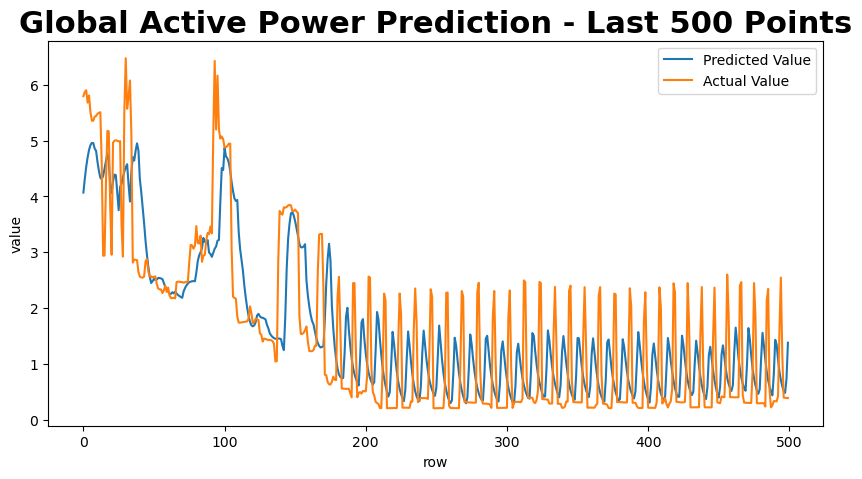

In [ ]:
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Comparing the validation performance depicted in the two graphs, it seems that the adjustments made to the LSTM model have not resulted in significant changes to the prediction accuracy on the validation data. The predicted values in both graphs exhibit similar patterns, capturing the overall trends but still diverging from the actual values at several points, especially at the peaks and troughs. The changes, which included modifying the learning rate, shape, and number of hidden units, were aimed at refining the model's learning process and increasing its capacity to capture more complex patterns. However, they appear to have had a limited effect, possibly because the model was already performing near its capacity with the given features or the adjustments were not substantial enough to make a noticeable difference. For further optimization, it would be beneficial to explore additional features that could provide the model with more context, further tune hyperparameters, or experiment with different architectures such as integrating convolutional layers for feature extraction.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Comparing the models developed in this assignment to the linear regression model from last week, it's clear that each model has its strengths and considerations for an IoT system. The LSTM models (particularly the optimized version with a MSE of 3.7005) are sophisticated and capable of capturing complex patterns in the data, potentially offering better performance in scenarios with non-linear relationships. However, they are computationally more intensive which could be a limitation for some IoT devices.

On the other hand, the linear regression model, with an MSE of 1.4444, though less sophisticated, is much simpler and requires significantly less computational power, making it an ideal candidate for IoT devices that are constrained by resources. It is also faster to train and easier to implement, which can be beneficial for rapid deployment and maintenance. Given its lower complexity, linear regression may not capture complex patterns as effectively as LSTM models, but its performance gives a competative edge, as evidenced by the lower MSE.

For an IoT system predicting GAP for a single household with a 5-minute predictive horizon, I would lean towards the linear regression model, primarily due to its simplicity, computational efficiency, and lower error rate as demonstrated by the MSE. If the IoT device in question has the capability to handle more complex computations and the use-case demands higher accuracy, an LSTM model could be chosen. But for this device the linear regression model would be a more practical and cost-effective option.

